In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('seaborn-whitegrid')
pd.set_option("display.precision", 5)

In [2]:
# magic to reload modules automatically
%load_ext autoreload
%autoreload 2

In [3]:
ff = pd.read_excel('data/5factors.xlsx')
rt = pd.read_excel('data/north.xlsx' , skiprows=3)
esg = pd.read_excel('data/north31.xlsx', skiprows=3)
print(rt.shape)
print(esg.shape)
print(ff.shape)

(2352, 124)
(12, 739)
(8261, 7)


In [4]:
pd.set_option('display.max_columns',735) # I want to see all the columns
pd.set_option('display.max_rows',735) 

In [5]:
ff.rename(columns = {'Unnamed: 0' : 'date'}, inplace=True)
ff['date'] = pd.to_datetime(ff['date'], format='%Y%m%d')
filt = (ff['date'] >= pd.to_datetime('2013-04-03')) & (ff['date'] <= pd.to_datetime('2022-02-28'))
ff = ff[filt]
ff.reset_index(inplace = True, drop = True)

In [6]:
rt.drop(index=[0,1,2], inplace=True)
rt.reset_index(inplace = True, drop = True) # Drop old index too

In [7]:
it = rt.copy()
it.to_excel('it.xlsx')

In [8]:
rt.rename(columns={'Unnamed: 0':'date'},inplace = True) 
xx = ['1COV GY Equity','DTG GY Equity','SINCH SS Equity',
                 'SHL GY Equity','NEL NO Equity','DHER GY Equity',
                 'HFG GY Equity','LIN GY Equity','NETS DC Equity',
                 'DAX Index','OMXS30B Index','OMXC25 Index','OMX Index']
drop_these = []
for i in xx:
    for j in range(1,6):
        drop_these.append(i + '.' + str(j))
drop_these = xx + drop_these
rt.drop(columns=xx, inplace = True)

In [9]:
rt.columns = rt.columns.str.replace(' GY', ' G')
rt.columns = rt.columns.str.replace(' SS', ' S')
rt.columns = rt.columns.str.replace(' NO', ' N')
rt.columns = rt.columns.str.replace(' DC', ' D')
rt.columns = rt.columns.str.replace(' Equity', '')
rt.columns = rt.columns.str.replace(' ', '_')

In [10]:
rt['date'] = pd.to_datetime(rt['date'])
#rt.set_index('date',inplace = True) 

In [11]:
esg.drop(columns=drop_these,inplace = True) 
esg.drop(index=[0,2], inplace=True)
esg.rename(columns={'Unnamed: 0':'Date'},inplace = True) 
esg.reset_index(inplace = True, drop = True) 

In [12]:
esg.replace({'ESG_DISCLOSURE_SCORE': 'ESG', 'ENVIRON_DISCLOSURE_SCORE': 'E',
             'SOCIAL_DISCLOSURE_SCORE': 'S','GOVNCE_DISCLOSURE_SCORE': 'G',
             'HISTORICAL_MARKET_CAP' : 'HMCAP', 'CUR_MKT_CAP': 'MCAP'}, inplace=True)

In [13]:
asg = esg.iloc[1] + ' ' + esg.iloc[0]
esg = esg.append(asg, ignore_index=True)
esg.loc[10,'Date'] = 'date'
nnn = esg.loc[10]
esg.rename(columns=nnn, inplace=True)
esg.drop(index=[0,1,10], inplace=True)
esg.reset_index(inplace = True, drop = True)

In [14]:
esg.columns = esg.columns.str.replace(' GY', ' G')
esg.columns = esg.columns.str.replace(' SS', ' S')
esg.columns = esg.columns.str.replace(' NO', ' N')
esg.columns = esg.columns.str.replace(' DC', ' D')
esg.columns = esg.columns.str.replace(' Equity', '')
esg.columns = esg.columns.str.replace(' ', '_')
esg.set_index('date', inplace=True)

In [15]:
esg_esg = esg.loc[:,'ADS_G_ESG':'VWS_D_ESG']
esg_esg.columns = esg_esg.columns.str.replace('_ESG', '')

In [16]:
for i in rt.columns[1:]:
    rt.loc[:,i] = rt.loc[:,i].pct_change(1)*100
rt.drop(index=[0], inplace=True)

In [17]:
nyind = []
for i in esg_esg.index:
    nyind.append(str(i)+ '_esg')
esg_esg.index = nyind

In [18]:
rtt = pd.concat([rt, esg_esg])

In [19]:
#rtt.drop(columns='EVO_S', inplace=True)
#rt.drop(columns='EVO_S', inplace=True)

In [20]:
filt = (rtt['date'] >= pd.to_datetime('2013-01-01')) & (rtt['date'] <= pd.to_datetime('2013-12-31')) 
thirteen = rtt[filt]
thirteen = pd.concat([thirteen, esg_esg])
thirteen = thirteen.replace(0, np.nan)
thirteen.dropna(how='all', axis='columns', thresh=150, inplace=True)
thirteen = thirteen.replace(np.nan, 0)
print(thirteen.shape)

(203, 103)


In [21]:
#  2013
q_l = thirteen.loc[thirteen.index[-8], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = thirteen.loc[thirteen.index[-8], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (thirteen.loc['2014_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (thirteen.loc['2014_esg', 'ADS_G':'VWS_D'] > q_l) & (thirteen.loc['2014_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (thirteen.loc['2014_esg', 'ADS_G':'VWS_D'] > q_h)

In [22]:
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum
thirteen.sort_values(by = '2014_esg', axis = 1, na_position ='first', inplace=True)

In [23]:
#2013
# low
thirteen = thirteen.iloc[:-8]
low_p=[]
for i in range(len(thirteen)):
     low_p.append(thirteen.iloc[i, 1:I_sum].mean())

# mid
mid_p=[]
for i in range(len(thirteen)):
     mid_p.append(thirteen.iloc[i, I_sum:Ii_sum].mean())

# high
high_p=[]
for i in range(len(thirteen)):
     high_p.append(thirteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [24]:
filt = (rtt['date'] >= pd.to_datetime('2014-01-01')) & (rtt['date'] <= pd.to_datetime('2014-12-31')) 
fourteen = rtt[filt]
fourteen = pd.concat([fourteen, esg_esg])
fourteen = fourteen.replace(0, np.nan)
fourteen.dropna(how='all', axis='columns', thresh=100, inplace=True)
fourteen = fourteen.replace(np.nan, 0)
fourteen.sort_values(by = '2014_esg', axis = 1, na_position ='first', inplace=True)

In [25]:
#2014
# low
fourteen = fourteen.iloc[:-8]
for i in range(len(fourteen)):
     low_p.append(fourteen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(fourteen)):
     mid_p.append(fourteen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(fourteen)):
     high_p.append(fourteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [26]:
#  2015
filt = (rtt['date'] >= pd.to_datetime('2015-01-01')) & (rtt['date'] <= pd.to_datetime('2015-12-31')) 
fifteen = rtt[filt]
fifteen = pd.concat([fifteen, esg_esg])
fifteen = fifteen.replace(0, np.nan)
fifteen.dropna(how='all', axis='columns', thresh=100, inplace=True)
fifteen = fifteen.replace(np.nan, 0)
nah = ['2014_esg','2016_esg','2017_esg','2018_esg','2019_esg','2020_esg','2021_esg']
fifteen.drop(index=nah, inplace=True)

q_l = fifteen.loc[fifteen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = fifteen.loc[fifteen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (fifteen.loc['2015_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (fifteen.loc['2015_esg', 'ADS_G':'VWS_D'] > q_l) & (fifteen.loc['2015_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (fifteen.loc['2015_esg', 'ADS_G':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum

In [27]:
fifteen.sort_values(by = '2015_esg', axis = 1, na_position ='first', inplace=True)

In [28]:
#2015
# low
fifteen = fifteen.iloc[:-1]
for i in range(len(fifteen)):
     low_p.append(fifteen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(fifteen)):
     mid_p.append(fifteen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(fifteen)):
     high_p.append(fifteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [29]:
#  2016
filt = (rtt['date'] >= pd.to_datetime('2016-01-01')) & (rtt['date'] <= pd.to_datetime('2016-12-31')) 
sixteen = rtt[filt]
sixteen = pd.concat([sixteen, esg_esg])
sixteen = sixteen.replace(0, np.nan)
sixteen.dropna(how='all', axis='columns', thresh=120, inplace=True)
sixteen = sixteen.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2017_esg','2018_esg','2019_esg','2020_esg','2021_esg']
sixteen.drop(index=nah, inplace=True)

q_l = sixteen.loc[sixteen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = sixteen.loc[sixteen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (sixteen.loc['2016_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (sixteen.loc['2016_esg', 'ADS_G':'VWS_D'] > q_l) & (sixteen.loc['2016_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (sixteen.loc['2016_esg', 'ADS_G':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum

In [30]:
sixteen.sort_values(by = '2016_esg', axis = 1, na_position ='first', inplace=True)

In [31]:
#  2016
# low
sixteen = sixteen.iloc[:-1]
for i in range(len(sixteen)):
     low_p.append(sixteen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(sixteen)):
     mid_p.append(sixteen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(sixteen)):
     high_p.append(sixteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [32]:
#  2017
filt = (rtt['date'] >= pd.to_datetime('2017-01-01')) & (rtt['date'] <= pd.to_datetime('2017-12-31')) 
seventeen = rtt[filt]
seventeen = pd.concat([seventeen, esg_esg])
seventeen = seventeen.replace(0, np.nan)
seventeen.dropna(how='all', axis='columns', thresh=120, inplace=True)
seventeen = seventeen.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2018_esg','2019_esg','2020_esg','2021_esg']
seventeen.drop(index=nah, inplace=True)

q_l = seventeen.loc[seventeen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = seventeen.loc[seventeen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (seventeen.loc['2017_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (seventeen.loc['2017_esg', 'ADS_G':'VWS_D'] > q_l) & (seventeen.loc['2017_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (seventeen.loc['2017_esg', 'ADS_G':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum

In [33]:
seventeen.sort_values(by = '2017_esg', axis = 1, na_position ='first', inplace=True)

In [34]:
#  2017
# low
seventeen = seventeen.iloc[:-1]
for i in range(len(seventeen)):
     low_p.append(seventeen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(seventeen)):
     mid_p.append(seventeen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(seventeen)):
     high_p.append(seventeen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [35]:
#  2018
filt = (rtt['date'] >= pd.to_datetime('2018-01-01')) & (rtt['date'] <= pd.to_datetime('2018-12-31')) 
eighteen  = rtt[filt]
eighteen = pd.concat([eighteen, esg_esg])
eighteen = eighteen.replace(0, np.nan)
eighteen.dropna(how='all', axis='columns', thresh=120, inplace=True)
eighteen = eighteen.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2017_esg','2019_esg','2020_esg','2021_esg']
eighteen.drop(index=nah, inplace=True)

q_l = eighteen.loc[eighteen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = eighteen.loc[eighteen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (eighteen.loc['2018_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (eighteen.loc['2018_esg', 'ADS_G':'VWS_D'] > q_l) & (eighteen.loc['2018_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (eighteen.loc['2018_esg', 'ADS_G':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum

In [36]:
eighteen.sort_values(by = '2018_esg', axis = 1, na_position ='first', inplace=True)

In [37]:
#  2018
# low
eighteen = eighteen.iloc[:-1]
for i in range(len(eighteen)):
     low_p.append(eighteen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(eighteen)):
     mid_p.append(eighteen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(eighteen)):
     high_p.append(eighteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [38]:
#  2019
filt = (rtt['date'] >= pd.to_datetime('2019-01-01')) & (rtt['date'] <= pd.to_datetime('2019-12-31')) 
nineteen  = rtt[filt]
nineteen = pd.concat([nineteen, esg_esg])
nineteen = nineteen.replace(0, np.nan)
nineteen = nineteen.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2017_esg','2018_esg','2020_esg','2021_esg']
nineteen.drop(index=nah, inplace=True)

q_l = nineteen.loc[nineteen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = nineteen.loc[nineteen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (nineteen.loc['2019_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (nineteen.loc['2019_esg', 'ADS_G':'VWS_D'] > q_l) & (nineteen.loc['2019_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (nineteen.loc['2019_esg', 'ADS_G':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum

In [39]:
nineteen.sort_values(by = '2019_esg', axis = 1, na_position ='first', inplace=True)

In [40]:
#  2019
# low
nineteen = nineteen.iloc[:-1]
for i in range(len(nineteen)):
     low_p.append(nineteen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(nineteen)):
     mid_p.append(nineteen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(nineteen)):
     high_p.append(nineteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [41]:
#  2020
filt = (rtt['date'] >= pd.to_datetime('2020-01-01')) & (rtt['date'] <= pd.to_datetime('2020-12-31')) 
twenty   = rtt[filt]
twenty = pd.concat([twenty, esg_esg])
twenty = twenty.replace(0, np.nan)
twenty = twenty.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2017_esg','2018_esg','2019_esg','2021_esg']
twenty.drop(index=nah, inplace=True)

q_l = twenty.loc[twenty.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = twenty.loc[twenty.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (twenty.loc['2020_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (twenty.loc['2020_esg', 'ADS_G':'VWS_D'] > q_l) & (twenty.loc['2020_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (twenty.loc['2020_esg', 'ADS_G':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum

In [42]:
twenty.sort_values(by = '2020_esg', axis = 1, na_position ='first', inplace=True)

In [43]:
#  2020
# low
twenty = twenty.iloc[:-1]
for i in range(len(twenty)):
     low_p.append(twenty.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(twenty)):
     mid_p.append(twenty.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(twenty)):
     high_p.append(twenty.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [44]:
#  2021
filt = (rtt['date'] >= pd.to_datetime('2021-01-01')) & (rtt['date'] <= pd.to_datetime('2021-12-31')) 
twentyone = rtt[filt]
twentyone = pd.concat([twentyone, esg_esg])
twentyone = twentyone.replace(0, np.nan)
twentyone = twentyone.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2017_esg','2018_esg','2019_esg','2020_esg']
twentyone.drop(index=nah, inplace=True)

q_l = twentyone.loc[twentyone.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = twentyone.loc[twentyone.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (twentyone.loc['2021_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (twentyone.loc['2021_esg', 'ADS_G':'VWS_D'] > q_l) & (twentyone.loc['2021_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (twentyone.loc['2021_esg', 'ADS_G':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum

In [45]:
twentyone.sort_values(by = '2021_esg', axis = 1, na_position ='first', inplace=True)

In [46]:
#  2021
# low
twentyone = twentyone.iloc[:-1]
for i in range(len(twentyone)):
     low_p.append(twentyone.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(twentyone)):
     mid_p.append(twentyone.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(twentyone)):
     high_p.append(twentyone.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [47]:
#  2022
filt = (rtt['date'] >= pd.to_datetime('2022-01-01')) & (rtt['date'] <= pd.to_datetime('2022-04-02')) 
twentytwo = rtt[filt]
twentytwo = pd.concat([twentytwo, esg_esg])
twentytwo = twentytwo.replace(0, np.nan)
twentytwo = twentytwo.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2017_esg','2018_esg','2019_esg','2020_esg']
twentytwo.drop(index=nah, inplace=True)

q_l = twentytwo.loc[twentytwo.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = twentytwo.loc[twentytwo.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (twentytwo.loc['2021_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (twentytwo.loc['2021_esg', 'ADS_G':'VWS_D'] > q_l) & (twentytwo.loc['2021_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (twentytwo.loc['2021_esg', 'ADS_G':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum

In [48]:
twentytwo.sort_values(by = '2021_esg', axis = 1, na_position ='first', inplace=True)

In [49]:
#  2022
# low
twentytwo = twentytwo.iloc[:-1]
for i in range(len(twentytwo)):
     low_p.append(twentytwo.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(twentytwo)):
     mid_p.append(twentytwo.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(twentytwo)):
     high_p.append(twentytwo.iloc[i, Ii_sum:Iii_sum + 1].mean())

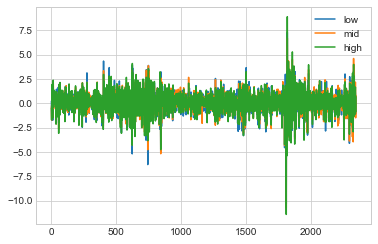

In [50]:
plt.plot(low_p, label = 'low')
plt.plot(mid_p, label = 'mid')
plt.plot(high_p, label = 'high')
plt.legend();

In [51]:
rt['port_low'] = low_p
rt['port_mid'] = mid_p
rt['port_high'] = high_p

In [52]:
rt.to_excel('rt.xlsx')
ff.to_excel('ff.xlsx')
esg_esg.to_excel('esg_esg.xlsx')

In [53]:
test = rt.copy()
test = test.replace(0, np.nan)
test.dropna(how='all', axis='index', thresh=4, inplace=True)
test = test.replace(np.nan, 0)
tab = test.describe()

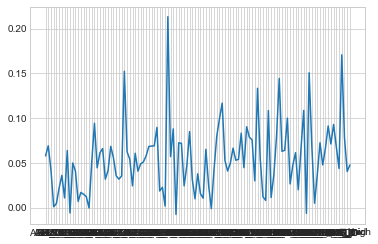

In [54]:
plt.plot(tab.loc['mean',:]);

In [55]:
high_r = tab.loc['mean',:].sort_values(ascending=False).tolist()
tab.loc['mean',:].sort_values(ascending=False).head()

EVO_S      0.21323
VWS_D      0.17069
SRT3_G     0.15236
GMAB_D     0.15066
AMBUB_D    0.14433
Name: mean, dtype: float64

In [56]:
esg_high_r = esg_esg.loc[:,['EVO_S','VWS_D','SRT3_G','GMAB_D','AMBUB_D','SALM_N','BAKKA_N','DSV_D','TOM_N','BAVA_D' ]].mean().tolist()

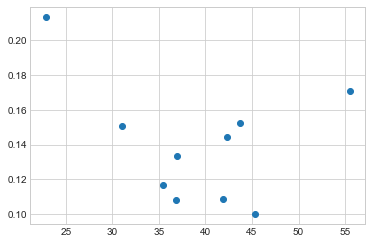

In [57]:
plt.scatter(esg_high_r,high_r[:10]);

In [58]:
high_l = tab.loc['mean',:].sort_values(ascending=True).tolist()
high_l=high_l[:10]
high_l

[-0.007577846288507962,
 -0.0064064096904672555,
 -0.005931230426752646,
 -0.0010747911778650062,
 -0.0003733766893817676,
 0.0010157417762705102,
 0.0017071686303182874,
 0.004610171886979687,
 0.004888015296645593,
 0.006963521387807491]

In [59]:
esg_high_l = esg_esg.loc[:,['HMB_S','FLS_D','DBK_G','TELIA_S','HEN3_G','BAS_G','ESSITYB_S','BAYN_G','ISS_D','EOAN_G' ]].mean().tolist()
esg_high_l

[43.33820000000001,
 45.759975000000004,
 45.59904999999999,
 47.585762499999994,
 51.610749999999996,
 62.9300375,
 60.69344999999999,
 67.94212499999999,
 49.638912499999996,
 60.41645]

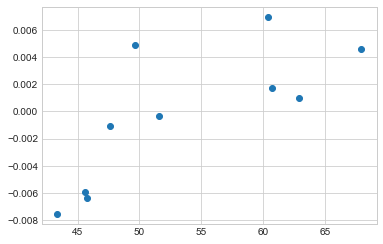

In [60]:
plt.scatter(esg_high_l,high_l);

In [61]:
rtt_test.tail(20)

NameError: name 'rtt_test' is not defined

In [ ]:
esg

In [ ]:
esg.loc[:,['DBK_G_ESG','DBK_G_E','DBK_G_S','DBK_G_G']]

In [ ]:
DANSKE_D

In [ ]:
esg.loc[:,['DANSKE_D_ESG','DANSKE_D_E','DANSKE_D_S','DANSKE_D_G']]